# Import

In [60]:
import joblib
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Data Preparation

In [61]:

# Load the data
data = pd.read_csv('data_06_23_to_06_24.csv')

In [62]:
# Convert date column to datetime
data['date'] = pd.to_datetime(data['date'])

# Set date as index
data.set_index('date', inplace=True)

In [63]:
# Fill NaN values with the mean of the respective column
data.fillna(data.mean(), inplace=True)

In [64]:
# Select relevant features (excluding the target variable)
features = data.drop(columns=['temperature_2m'])

In [65]:
# Target variable
target = data['temperature_2m']

In [66]:
# Scale the features and target
scaler_features = MinMaxScaler()
scaler_target = MinMaxScaler()

features_scaled = scaler_features.fit_transform(features)
target_scaled = scaler_target.fit_transform(target.values.reshape(-1, 1))

In [67]:
# Create a function to prepare the data for time series forecasting
def create_dataset(features, target, time_step=1):
    X, y = [], []
    for i in range(len(features) - time_step):
        X.append(features[i:(i + time_step), :])
        y.append(target[i + time_step])
    return np.array(X), np.array(y)

In [68]:
# Define the time step (e.g., 24 hours for a daily prediction)
time_step = 24

# Create the dataset
X, y = create_dataset(features_scaled, target_scaled, time_step)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Training

In [69]:
# Define the LSTM model
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(50, return_sequences=True, input_shape=(time_step, X_train.shape[2])),
    tf.keras.layers.LSTM(50, return_sequences=False),
    tf.keras.layers.Dense(25),
    tf.keras.layers.Dense(1)
])

c:\Users\florent\_python_environments\orchestration_venv_v2\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [70]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [71]:
# Train the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=32)

Epoch 1/20
233/233 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - loss: 0.0152 - val_loss: 0.0014
Epoch 2/20
233/233 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - loss: 0.0014 - val_loss: 9.4641e-04
Epoch 3/20
233/233 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 9.3217e-04 - val_loss: 8.0779e-04
Epoch 4/20
233/233 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 7.2600e-04 - val_loss: 7.5752e-04
Epoch 5/20
233/233 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 6.3981e-04 - val_loss: 6.3543e-04
Epoch 6/20
233/233 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - loss: 5.6777e-04 - val_loss: 4.5072e-04
Epoch 7/20
233/233 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 4.2861e-04 - val_loss: 4.0124e-04
Epoch 8/20
233/233 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - loss: 4.3118e-04 - val_loss: 4.6525e-04
Epoch 9/20
233/233 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 3.8844e-04 - val_loss: 3.7548e-04
Epoch 10/20
233/233 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 3.8483e-04 - val_loss: 2.9442e-04
Epoch 11/20
233/233 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss:

# Evaluation

In [72]:
# Predict on the test set
y_pred_scaled = model.predict(X_test)

59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step


In [73]:
# Inverse transform the predictions and the actual values
y_pred = scaler_target.inverse_transform(y_pred_scaled)
y_test_actual = scaler_target.inverse_transform(y_test)

In [74]:
scaler_target

MinMaxScaler()

In [75]:
# Calculate evaluation metrics
mse = mean_squared_error(y_test_actual, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_actual, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"R-squared Score: {r2}")

Mean Squared Error: 0.5897375273177102
Root Mean Squared Error: 0.7679437006172459
R-squared Score: 0.9868184190476915


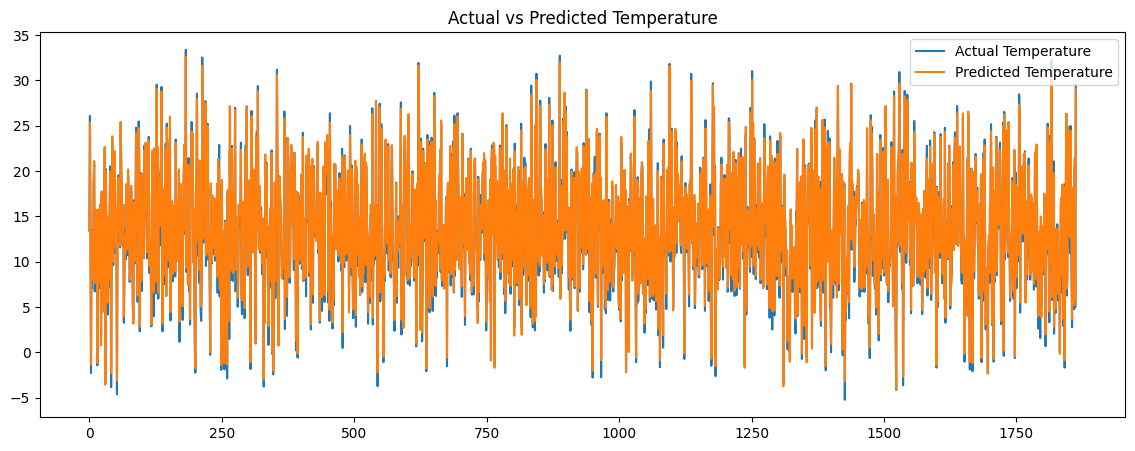

In [76]:
# Plot actual vs predicted values
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))
plt.plot(y_test_actual, label='Actual Temperature')
plt.plot(y_pred, label='Predicted Temperature')
plt.legend()
plt.title('Actual vs Predicted Temperature')
plt.show()

# Save Model & scaler

In [77]:
model.save("./static/models/lstm_v1.keras")

In [78]:
joblib.dump(scaler_features, './static/scalers/scaler_features_v1.pkl')
joblib.dump(scaler_target, './static/scalers/scaler_target_v1.pkl')

['./static/scalers/scaler_target_v1.pkl']